<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [15]:
df = pd.read_csv('/datasets/Churn.csv', index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим, можно ли использовать CustomerId как уникальный индекс, чтобы избавиться от нескольких колонок, решающих одну и ту же задачу.

In [16]:
df['CustomerId'].duplicated().sum()

0

Все значения уникальны, поэтому сделаем `CustomerId` индексом.

In [17]:
df.set_index('CustomerId', inplace=True)
df.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Изучаем пропущенные значения. 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           9091 non-null   float64
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1015.6+ KB


Видно, что `Tenure` имеет 909 пустых значений. Посмотрим, что там за клиенты:

In [19]:
df[ df['Tenure'].isna() ].head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,,
15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


Вполне подходящие клиенты. Можно попробовать заменить пустые значения медианой:

In [21]:
df['Tenure'] = df['Tenure'].fillna( df['Tenure'].median() )

Фамилия клиента скорее всего не влияет на churn-rate, поэтому удалим эту колонку:

In [22]:
df.drop(['Surname'], inplace=True, axis=1)

Проверим, какие страны есть в колонке `Geography`:

In [23]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Всего 3 страны и 2 пола. Можно воспользоваться методом `get_dummies` для разбиения категориальных колонок на отдельные колонки.

In [24]:
df_converted = pd.get_dummies(df, drop_first=True)
df_converted.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,,
15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Готовим обучающую, валидационную и тестовую выборки в соотношении 80/10/10%:

In [25]:
target = df_converted['Exited']
features = df_converted.drop('Exited', axis=1)

features_train, features_test_valid, target_train, target_test_valid = train_test_split(features, target, test_size=0.2, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test_valid, target_test_valid, test_size=0.5, random_state=12345)


## Исследование задачи

Проверим основные метрики с помощью алгоритма `RandomForestClassifier`: 

In [26]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1-score:', f1_score(target_valid, predicted_valid))
print('Recall score:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))

Accuracy: 0.845
F1-score: 0.5110410094637224
Recall score: 0.400990099009901
Precision: 0.7043478260869566


Проверим адекватность модели на нулевых ответах:

In [27]:
print('Accuracy with 0:', accuracy_score(target_valid, pd.Series(0, index=range(target_valid.shape[0]))))

Accuracy with 0: 0.798


И заодно посмотрим на матрицу ошибок:

In [30]:
print(confusion_matrix(target_valid, predicted_valid))

[[764  34]
 [121  81]]


Посчитаем также ROC-AUC

In [31]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.4
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC: 0.8675711556118018


Модель выглядит адекватной. Предсказания по всем нулям менее аккуратны, чем по всем классам. Но при этом модель довольно часто ошибается. И F1 не дотягивает до 0.59. Далее изучим, насколько модель несбалансирована.

## Борьба с дисбалансом

Оценим, сколько клиентов в каждом классе:

In [32]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Дисбаланс заметен, но не 9:1, хотя и не 1:1. Попробуем его уменьшить и изучить результат.

Для начала попробуем логистическую регрессию с настройкой баланса:

In [33]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1-score:', f1_score(target_valid, predicted_valid))
print('Recall score:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))

Accuracy: 0.696
F1-score: 0.48474576271186437
Recall score: 0.7079207920792079
Precision: 0.36855670103092786


F1 мера снизилась. Алгоритм в такой реализации нам не подходит. Продолжим тестировать на `RandomForestClassifier`.

Увеличим кол-во положительных таргетов в 4 раза (чтобы сравнять с кол-во отрицательных):

In [38]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predicted_valid))
print('F1-score:', f1_score(target_valid, predicted_valid))
print('Recall score:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))

Accuracy: 0.848
F1-score: 0.5846994535519127
Recall score: 0.5297029702970297
Precision: 0.6524390243902439


F1 еще меньше, чем 0.59, но близко. Но попробуем что-нибудь еще. Уменьшать выборки не будем. Есть еще варианты работы с порогом классификации. В нашей бизнес-задаче лучше растить метрику `recall`, чтобы предотвратить отток клиентов. Пробуем повлиять на метрику `Recall`.

In [43]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.9, 0.1):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1: {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1: 0.338
Порог = 0.10 | Точность = 0.302, Полнота = 0.965, F1: 0.460
Порог = 0.20 | Точность = 0.390, Полнота = 0.871, F1: 0.539
Порог = 0.30 | Точность = 0.481, Полнота = 0.757, F1: 0.588
Порог = 0.40 | Точность = 0.551, Полнота = 0.639, F1: 0.592
Порог = 0.50 | Точность = 0.652, Полнота = 0.530, F1: 0.585
Порог = 0.60 | Точность = 0.701, Полнота = 0.441, F1: 0.541
Порог = 0.70 | Точность = 0.753, Полнота = 0.347, F1: 0.475
Порог = 0.80 | Точность = 0.815, Полнота = 0.262, F1: 0.397


`F1` и `recall` получают наилучший результат при пороге `0.4`. 

Посчитаем также ROC-AUC для данной модели:

In [44]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.4
print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

AUC-ROC: 0.861333407776868


## Тестирование модели

Протестируем модель на валидационных данных с порогом 0.4. Тестировать будем все метрики, а также адекватность.

In [45]:
model = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)
model.fit(features_upsampled, target_upsampled)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > 0.4
    
print('Accuracy:', accuracy_score(target_test, predicted_test))
print('F1-score:', f1_score(target_test, predicted_test))
print('Recall score:', recall_score(target_test, predicted_test))
print('Precision:', precision_score(target_test, predicted_test))

print('Accuracy with 0:', accuracy_score(target_test, pd.Series(0, index=range(target_test.shape[0]))))
print('F1-score with 0:', f1_score(target_test, pd.Series(0, index=range(target_test.shape[0]))))
print('Recall with 0:', recall_score(target_test, pd.Series(0, index=range(target_test.shape[0]))))
print('Precision with 0:', precision_score(target_test, pd.Series(0, index=range(target_test.shape[0]))))


Accuracy: 0.823
F1-score: 0.6304801670146138
Recall score: 0.6711111111111111
Precision: 0.594488188976378
Accuracy with 0: 0.775
F1-score with 0: 0.0
Recall with 0: 0.0
Precision with 0: 0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Изучим кривую AUC-ROC

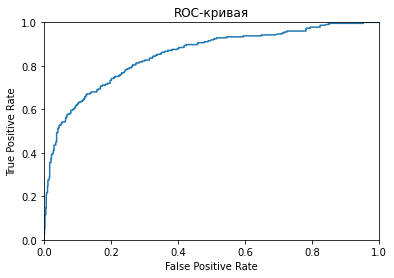

In [47]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

И посчитаем AUC-ROC:

In [48]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.861333407776868


Вывод: лучшие результаты работы по данному датасету у `RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=16)` с `threshold=0.4`.

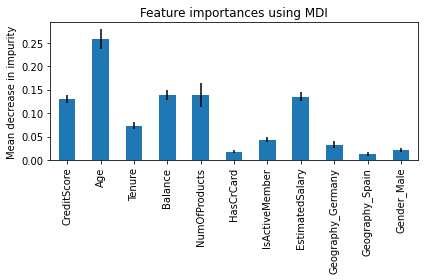

In [57]:
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=features.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Как видно, наибольшую важность играет возраст. Дальше равноценны кредитный рейтинг, баланс на счету, кол-во подключенных продуктов и зарплата.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*